# Exploring NARCliM 2.0 Data via NCI THREDDS

This notebook demonstrates how to access, explore, and visualise  
**NARCliM 2.0 climate data** directly from the **NCI THREDDS server** using Python.

The notebook is designed as:
- A **reusable demonstration notebook** for stakeholders
- A **starter template** for future CSI datasets
- A **grid-aware exploratory workflow** (no implicit regridding)

The focus is on **quick, transparent analysis and visualisation** rather than
production-grade spatial products.


## 1. Introduction & Task Context

This notebook was developed as part of **Task 2**, which aims to create
clear and reusable Python/Jupyter examples for accessing climate data
hosted on **NCI’s THREDDS infrastructure**.

Although the examples use **NARCliM 2.0** data, the workflow is intentionally
generic and can be easily adapted to future **CSI datasets** once they are
available via THREDDS.

The notebook prioritises:
- Interactive exploration
- Minimal data movement (remote access)
- Transparency in spatial grid handling


## 2. Environment Setup

The following Python libraries are used for:
- Discovering datasets via the THREDDS catalogue
- Accessing NetCDF data remotely using OPeNDAP
- Interactive visualisation and analysis

The installation step only needs to be run once per environment.


In [1]:
import requests
import xml.etree.ElementTree as ET
from urllib.parse import urljoin
import re
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

## 3. Accessing NARCliM Data via THREDDS

NCI provides access to climate data through a **THREDDS Data Server**, which enables:

- Programmatic discovery of available datasets
- Remote access to NetCDF files via **OPeNDAP**
- Lazy loading of data without downloading large files

This notebook uses helper functions to:
- Convert OPeNDAP URLs into catalogue URLs
- List available datasets and files
- Select appropriate files based on user-defined time ranges


In [2]:
NS = {
    "cat": "http://www.unidata.ucar.edu/namespaces/thredds/InvCatalog/v1.0",
    "xlink": "http://www.w3.org/1999/xlink",
}

def catalog_xml_from_opendap_dir(opendap_dir_url: str) -> str:
    if "/thredds/dodsC/" in opendap_dir_url:
        cat = opendap_dir_url.replace("/thredds/dodsC/", "/thredds/catalog/")
    else:
        cat = opendap_dir_url
    return cat.rstrip("/") + "/catalog.xml"

def list_subfolders_from_catalog(catalog_xml_url: str):
    xml = requests.get(catalog_xml_url, timeout=60).text
    root = ET.fromstring(xml)
    out = []
    for cr in root.findall(".//cat:catalogRef", NS):
        name = cr.get("name") or cr.get("{http://www.w3.org/1999/xlink}title")
        href = cr.get("{http://www.w3.org/1999/xlink}href")
        if name and href:
            out.append((name, urljoin(catalog_xml_url, href)))
    return out

def list_files_from_catalog(catalog_xml_url: str):
    xml = requests.get(catalog_xml_url, timeout=60).text
    root = ET.fromstring(xml)
    return [(ds.get("name"), ds.get("urlPath"))
            for ds in root.findall(".//cat:dataset[@urlPath]", NS)]

def opendap_url_from_urlpath(urlpath: str) -> str:
    return "https://dapds00.nci.org.au/thredds/dodsC/" + urlpath.lstrip("/")

def pick_file_by_timerange(files, start_yyyymm, end_yyyymm):
    rx = re.compile(r"_(\d{6})-(\d{6})\.nc$")
    parsed = []
    for name, urlpath in files:
        m = rx.search(name or "")
        if m:
            parsed.append((m.group(1), m.group(2), name, urlpath))

    overlapping = [p for p in parsed if not (p[1] < start_yyyymm or p[0] > end_yyyymm)]
    if overlapping:
        overlapping.sort(key=lambda x: x[1])
        return overlapping[-1][2], overlapping[-1][3]

    parsed.sort(key=lambda x: x[1])
    return parsed[-1][2], parsed[-1][3]


## 4. Dataset Configuration

To keep the workflow transparent and reproducible, dataset parameters
are defined explicitly.

By changing these values, users can easily switch:
- Domain
- Global climate model
- Experiment scenario
- Temporal frequency


In [3]:
BASE = "https://dapds00.nci.org.au/thredds/dodsC/zz63/NARCliM2-0/output-CMIP6/DD"

domain   = "AUS-18"
org      = "NSW-Government"
gcm      = "ACCESS-ESM1-5"
exp      = "ssp126"
variant  = "r6i1p1f1"
rcm      = "NARCliM2-0-WRF412R3"
version  = "v1-r1"
frequency = "mon"


## 5. Variable & Time Selection

The NARCliM monthly dataset contains a large number of climate variables.

To make exploration user-friendly, this notebook provides an interactive
interface that allows users to:
- Select a climate variable (e.g. tasmax, pr, clt)
- Choose a start year and end year

Once selected, the notebook automatically identifies the relevant NetCDF
file for analysis.


In [4]:
var_root = f"{BASE}/{domain}/{org}/{gcm}/{exp}/{variant}/{rcm}/{version}/{frequency}/"
cat = catalog_xml_from_opendap_dir(var_root)

vars_available = list_subfolders_from_catalog(cat)
var_names = sorted([name for name, _ in vars_available])

print(f"Found {len(var_names)} variables")
var_names[:10]


Found 112 variables


['CAPE',
 'CAPEmax',
 'CIN',
 'CINmax',
 'clivi',
 'clt',
 'clwvi',
 'evspsbl',
 'evspsblpot',
 'hfls']

### Interactive variable and time selection

The NARCliM monthly dataset contains a large number of climate variables.
To make exploration user-friendly, an interactive interface is provided that allows
the user to:

- Select a variable (e.g. tasmax, pr, clt)
- Select a start and end year

Once selected, the notebook automatically identifies and opens the corresponding
NetCDF file via OPeNDAP using xarray.


In [5]:
# =========================================================
# Imports
# =========================================================
import numpy as np
import pandas as pd
import xarray as xr
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display

# =========================================================
# 1) UI WIDGETS
# =========================================================
variable_dd = widgets.Dropdown(
    options=var_names,
    value="tasmax",
    description="Variable:",
    layout=widgets.Layout(width="220px")
)

start_year = widgets.SelectionSlider(
    options=[str(y) for y in range(1980, 2024)],
    value="2015",
    description="Start:",
    layout=widgets.Layout(width="300px")
)

end_year = widgets.SelectionSlider(
    options=[str(y) for y in range(1980, 2024)],
    value="2015",
    description="End:",
    layout=widgets.Layout(width="300px")
)

run_button = widgets.Button(
    description="Run analysis",
    button_style="success",
    layout=widgets.Layout(width="180px")
)

output = widgets.Output()

# =========================================================
# 2) DATASET LOADER
# =========================================================
def open_selected_dataset(variable, start_year, end_year):
    start_yyyymm = f"{start_year}01"
    end_yyyymm   = f"{end_year}12"

    latest_dir = f"{BASE}/{domain}/{org}/{gcm}/{exp}/{variant}/{rcm}/{version}/{frequency}/{variable}/latest/"
    cat = catalog_xml_from_opendap_dir(latest_dir)
    files = list_files_from_catalog(cat)

    name, urlpath = pick_file_by_timerange(files, start_yyyymm, end_yyyymm)
    opendap = opendap_url_from_urlpath(urlpath)

    print("Opening:", opendap)
    return xr.open_dataset(opendap, engine="pydap")

# =========================================================
# 3) CORE ANALYSIS PIPELINE
# =========================================================
def run_analysis():
    global ds

    # -------------------------
    # Load data
    # -------------------------
    ds = open_selected_dataset(
        variable_dd.value,
        start_year.value,
        end_year.value
    )

    var = variable_dd.value
    units = ds[var].attrs.get("units", "")

    # -------------------------
    # WA bounding box
    # -------------------------
    lon_min, lon_max = 110, 130
    lat_min, lat_max = -36, -12

    wa_mask = (
        (ds["lat"] >= lat_min) & (ds["lat"] <= lat_max) &
        (ds["lon"] >= lon_min) & (ds["lon"] <= lon_max)
    )

    da = ds[var].where(wa_mask)

    # -------------------------
    # Stats
    # -------------------------
    mean2d = da.mean("time", skipna=True)
    min2d  = da.min("time", skipna=True)
    max2d  = da.max("time", skipna=True)

    # -------------------------
    # Build stats dataset
    # -------------------------
    stats_ds = xr.Dataset(
        data_vars=dict(mean=mean2d, min=min2d, max=max2d),
        coords=dict(lon=ds["lon"], lat=ds["lat"])
    )

    # -------------------------
    # Flatten to dataframe
    # -------------------------
    df = (
        stats_ds
        .stack(point=("rlat", "rlon"))
        .to_dataframe()
        .reset_index()
        .dropna(subset=["mean"])
    )

    # -------------------------
    # Broad WA regions (reference points)
    # -------------------------
    regions_df = pd.DataFrame({
        "region": ["Perth Metro","South West","Wheatbelt","Great Southern",
                   "Mid West","Goldfields","Pilbara","Kimberley"],
        "lat":    [-31.95, -34.00, -31.50, -35.00, -28.80, -30.75, -22.50, -16.50],
        "lon":    [115.86, 115.20, 117.00, 117.80, 114.60, 121.50, 118.00, 125.00],
    })

    # -------------------------
    # Assign nearest region (vectorised)
    # -------------------------
    reg_lat = regions_df["lat"].to_numpy()
    reg_lon = regions_df["lon"].to_numpy()

    pts_lat = df["lat"].to_numpy()
    pts_lon = df["lon"].to_numpy()

    d2 = (pts_lat[:, None] - reg_lat[None, :])**2 + (pts_lon[:, None] - reg_lon[None, :])**2
    df["region"] = regions_df["region"].to_numpy()[d2.argmin(axis=1)]

    # -------------------------
    # Hover info
    # -------------------------
    customdata = np.column_stack([
        df["region"].to_numpy(),
        df["mean"].to_numpy(),
    ])

    hovertemplate = (
        "<b>%{customdata[0]}</b><br>"
        "Lon: %{x:.2f}, Lat: %{y:.2f}<br>"
        "Mean: %{customdata[1]:.2f} " + units +
        "<extra></extra>"
    )

    # =========================================================
    # 4) INTERACTIVE MAP (MEAN / MIN / MAX TOGGLE)
    # =========================================================
    def make_trace(stat, visible):
        return go.Scattergl(
            x=df["lon"],
            y=df["lat"],
            mode="markers",
            visible=visible,
            customdata=customdata,
            hovertemplate=hovertemplate,
            marker=dict(
                size=6,
                opacity=0.85,
                color=df[stat],
                colorscale="Inferno",
                colorbar=dict(title=f"{stat.capitalize()} ({units})") if visible else None
            ),
            name=stat.capitalize()
        )

    fig = go.Figure()
    fig.add_trace(make_trace("mean", True))
    fig.add_trace(make_trace("min", False))
    fig.add_trace(make_trace("max", False))

    fig.update_layout(
        title=f"{var} over Western Australia",
        xaxis=dict(title="Longitude", range=[lon_min, lon_max]),
        yaxis=dict(title="Latitude", range=[lat_min, lat_max],
                   scaleanchor="x", scaleratio=1),
        margin=dict(l=20, r=20, t=60, b=40),
        updatemenus=[dict(
            buttons=[
                dict(label="Mean", method="update",
                     args=[{"visible":[True, False, False]},
                           {"title": f"{var} Mean over WA"}]),
                dict(label="Min", method="update",
                     args=[{"visible":[False, True, False]},
                           {"title": f"{var} Minimum over WA"}]),
                dict(label="Max", method="update",
                     args=[{"visible":[False, False, True]},
                           {"title": f"{var} Maximum over WA"}]),
            ],
            direction="down",
            x=0.01, xanchor="left",
            y=1.12, yanchor="top"
        )]
    )

    fig.show()

# =========================================================
# 5) BUTTON CALLBACK
# =========================================================
def on_run_clicked(b):
    with output:
        output.clear_output()
        run_analysis()

run_button.on_click(on_run_clicked)

# =========================================================
# 6) CLEAN CONTROL PANEL LAYOUT
# =========================================================
row1 = widgets.HBox(
    [variable_dd, start_year, end_year],
    layout=widgets.Layout(justify_content="space-between")
)

row2 = widgets.HBox(
    [run_button],
    layout=widgets.Layout(justify_content="center", margin="10px 0")
)

control_panel = widgets.VBox(
    [row1, row2, output],
    layout=widgets.Layout(
        border="1px solid #ddd",
        padding="12px",
        width="100%",
        margin="10px 0"
    )
)

display(control_panel)


In [6]:
import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

# -------------------------
# Regions reference table
# -------------------------
def get_regions_df():
    return pd.DataFrame({
        "region": ["Perth Metro","South West","Wheatbelt","Great Southern",
                   "Mid West","Goldfields","Pilbara","Kimberley"],
        "lat":    [-31.95, -34.00, -31.50, -35.00, -28.80, -30.75, -22.50, -16.50],
        "lon":    [115.86, 115.20, 117.00, 117.80, 114.60, 121.50, 118.00, 125.00],
    })

regions_df = get_regions_df()

# -------------------------
# Region selector widget
# -------------------------
region_selector = widgets.SelectMultiple(
    options=regions_df["region"].tolist(),
    value=("Perth Metro", "South West"),
    description="WA Regions:",
    layout=widgets.Layout(width="320px", height="170px")
)

display(region_selector)


SelectMultiple(description='WA Regions:', index=(0, 1), layout=Layout(height='170px', width='320px'), options=…

In [9]:
import numpy as np

def extract_point_timeseries(ds, lat0, lon0, var):

    # distance to every grid point
    dist = (ds["lat"] - lat0)**2 + (ds["lon"] - lon0)**2

    # index of nearest point
    iy, ix = np.unravel_index(dist.argmin(), dist.shape)

    # extract time series at that grid point
    return ds[var].isel(rlat=iy, rlon=ix)



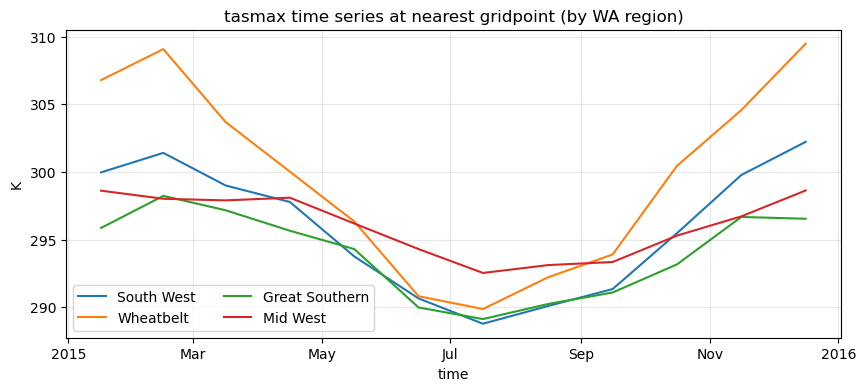

In [12]:
import matplotlib.pyplot as plt

var = variable_dd.value       
units = ds[var].attrs.get("units", "")

plt.figure(figsize=(10,4))

for region in region_selector.value:
    row = regions_df.loc[regions_df["region"] == region].iloc[0]
    ts = extract_point_timeseries(ds, row["lat"], row["lon"], var)
    ts.plot(label=region)

plt.title(f"{var} time series at nearest gridpoint (by WA region)")
plt.ylabel(units)
plt.legend(ncol=2)
plt.grid(True, alpha=0.3)
plt.show()


In [14]:
from ipywidgets import Widget
Widget.widgets = {}